# Imports

In [826]:
import os
from datetime import datetime, timedelta
import pandas as pd
from xgboost import XGBRegressor

import numpy as np

from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from xgboost import plot_importance
from matplotlib.patches import Patch

import hopsworks
from hsfs.feature import Feature

import warnings
warnings.filterwarnings("ignore", category=UserWarning)


# Feature Stores Retrieval from Hopsworks

## Login & Retrieve All Feature Stores

In [827]:
project = hopsworks.login(engine="python", project='terahidro2003')
fs = project.get_feature_store()

2025-11-11 01:18:45,012 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-11 01:18:45,017 INFO: Initializing external client
2025-11-11 01:18:45,017 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-11-11 01:18:46,230 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1286307


## Retrieve Air Quality and Wind Feature Stores

In [831]:
pm25_daily_fg = fs.get_feature_group(
    name="pm25_daily",
    version=1
)

wind_direction_daily_fg = fs.get_feature_group(
    name="wind_direction_daily",
    version=1
)

wind_speed_daily_fg = fs.get_feature_group(
    name="wind_speed_daily",
    version=1
)

air_temperature_daily_fg = fs.get_feature_group(
    name="air_temperature_daily",
    version=1
)

# Show what you actually got back for each FG call
print("pm_25_daily_fg:", "Loaded" if pm25_daily_fg is not None else "Not Loaded")
print("wind_direction_daily_fg:", "Loaded" if wind_direction_daily_fg is not None else "Not Loaded")
print("wind_speed_daily_fg:", "Loaded" if wind_speed_daily_fg is not None else "Not Loaded")
print("air_temperature_daily_fg:", "Loaded" if air_temperature_daily_fg is not None else "Not Loaded")

pm_25_daily_fg: Loaded
wind_direction_daily_fg: Loaded
wind_speed_daily_fg: Loaded
air_temperature_daily_fg: Loaded


# Feature View Creation

Join different feature groups (i.e., pm25, air speed and direction) together.

In [1035]:
REGION = "west"

selected_features = pm25_daily_fg.select(["pm25","pm25_lag_1d", "pm25_lag_2d", "pm25_lag_3d", "pm25_lag_7d", "pm25_lag_14d", "date", "region"]).filter(pm25_daily_fg.region == REGION).join(
    wind_direction_daily_fg.select_features(), on=["region", "date"]
).join(
    wind_speed_daily_fg.select_features(), on=["region", "date"]
).join(
    air_temperature_daily_fg.select_features(), on=["region", "date"]
)

2025-11-11 02:31:58,991 INFO: Using ['station_name', 'wind_direction_avg_mean', 'wind_direction_avg_max', 'wind_direction_avg_min', 'wind_direction_avg_std', 'latitude', 'longitude', 'day_of_week', 'day_of_month', 'month', 'year', 'is_weekend', 'wind_u', 'wind_v', 'wind_u_lag_1h', 'wind_v_lag_1h', 'wind_direction_lag_1h', 'wind_u_lag_2h', 'wind_v_lag_2h', 'wind_direction_lag_2h', 'wind_u_lag_3h', 'wind_v_lag_3h', 'wind_direction_lag_3h', 'wind_u_lag_6h', 'wind_v_lag_6h', 'wind_direction_lag_6h', 'wind_u_lag_12h', 'wind_v_lag_12h', 'wind_direction_lag_12h', 'wind_u_lag_24h', 'wind_v_lag_24h', 'wind_direction_lag_24h', 'wind_u_lag_48h', 'wind_v_lag_48h', 'wind_direction_lag_48h', 'wind_u_lag_72h', 'wind_v_lag_72h', 'wind_direction_lag_72h', 'wind_u_lag_168h', 'wind_v_lag_168h', 'wind_direction_lag_168h', 'wind_u_rolling_mean_6h', 'wind_v_rolling_mean_6h', 'direction_std_rolling_mean_6h', 'wind_u_rolling_mean_12h', 'wind_v_rolling_mean_12h', 'direction_std_rolling_mean_12h', 'wind_u_rolli

Create a feature view - selection of features from different feature groups that define I/O API of a model.

In [1090]:
feature_view = fs.get_or_create_feature_view(
    name="air_quality_wind_temperature_features_daily13",
    version=1,
    description="Feature view with air quality and weather features (wind speed/direction and temperature)",
    labels=['pm25'],
    query=selected_features
)

2025-11-11 03:15:50,830 WARNING: Ambiguous features detected during query construction.The feature `year` is present in feature groups ['air_temperature_daily version 1', 'wind_direction_daily version 1', 'wind_speed_daily version 1']. The feature `is_weekend` is present in feature groups ['air_temperature_daily version 1', 'wind_direction_daily version 1', 'wind_speed_daily version 1']. The feature `latitude` is present in feature groups ['air_temperature_daily version 1', 'wind_direction_daily version 1', 'wind_speed_daily version 1']. The feature `month` is present in feature groups ['air_temperature_daily version 1', 'wind_direction_daily version 1', 'wind_speed_daily version 1']. The feature `station_name` is present in feature groups ['air_temperature_daily version 1', 'wind_direction_daily version 1', 'wind_speed_daily version 1']. The feature `day_of_week` is present in feature groups ['air_temperature_daily version 1', 'wind_direction_daily version 1', 'wind_speed_daily versio

# Splitting the Data into Train/Test Data Sets

In [1091]:
start_date = "2025-10-01"

test_start = datetime.strptime(start_date, "%Y-%m-%d")
print("Test data starts from:", test_start.date())

Test data starts from: 2025-10-01


## Split data based on Start Date

In [1092]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(
    test_start=test_start
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (4.90s) 
2025-11-11 03:16:18,559 WARNING: VersionWarning: Incremented version to `1`.



### Output Samples from each set

In [1093]:
X_train.head(25000)

,pm25_lag_1d,pm25_lag_2d,pm25_lag_3d,pm25_lag_7d,pm25_lag_14d,date,region,station_name,wind_direction_avg_mean,wind_direction_avg_max,...,air_temperature_daily_air_temperature_rolling_min_24h,air_temperature_daily_air_temperature_rolling_max_24h,air_temperature_daily_air_temperature_rolling_mean_72h,air_temperature_daily_air_temperature_rolling_std_72h,air_temperature_daily_air_temperature_rolling_min_72h,air_temperature_daily_air_temperature_rolling_max_72h,air_temperature_daily_air_temperature_rolling_mean_168h,air_temperature_daily_air_temperature_rolling_std_168h,air_temperature_daily_air_temperature_rolling_min_168h,air_temperature_daily_air_temperature_rolling_max_168h
0,59.0,39.0,36.0,36.0,43.0,2024-02-27,west,Old Choa Chu Kang Road,34.716911,64.625211,...,27.114291,29.469353,27.521464,0.949947,24.689828,29.469353,28.019477,1.080949,24.689828,30.275160
1,56.0,68.0,45.0,32.0,41.0,2024-03-13,west,West Coast Highway,35.484975,42.483716,...,26.346756,29.532220,27.647483,0.974797,24.880854,29.532220,28.060898,1.021505,24.880854,30.146855
2,48.0,53.0,56.0,35.0,31.0,2024-03-15,west,West Coast Highway,56.129321,265.296247,...,26.790453,29.532220,27.718186,0.992178,24.880854,29.532220,28.069677,1.028140,24.880854,30.146855
3,47.0,48.0,53.0,45.0,36.0,2024-03-16,west,West Coast Highway,61.165033,324.470613,...,26.790453,29.532220,27.733711,1.002166,24.880854,29.532220,28.079312,1.028457,24.880854,30.146855
4,33.0,43.0,71.0,58.0,34.0,2024-04-26,west,West Coast Highway,93.588761,187.581874,...,26.633240,30.528053,28.938823,1.005458,26.346756,30.776928,28.167990,1.122230,24.880854,30.776928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3808,54.0,48.0,50.0,53.0,23.0,2023-10-05,west,None,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3809,44.0,44.0,53.0,55.0,30.0,2023-11-07,west,None,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3810,29.0,36.0,36.0,57.0,44.0,2023-11-20,west,None,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3811,30.0,25.0,34.0,31.0,21.0,2024-01-04,west,None,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1094]:
y_train

,pm25
0,53.0
1,53.0
2,47.0
3,44.0
4,65.0
...,...
3808,44.0
3809,41.0
3810,38.0
3811,19.0


In [1095]:
X_features = X_train.drop(columns=['date'])
X_test_features = X_test.drop(columns=['date'])
X_features.dropna(inplace=True)
mask = X_features.dropna().index
X_features = X_features.loc[mask].reset_index(drop=True)
y_train = y_train.loc[mask].reset_index(drop=True)
X_features

,pm25_lag_1d,pm25_lag_2d,pm25_lag_3d,pm25_lag_7d,pm25_lag_14d,region,station_name,wind_direction_avg_mean,wind_direction_avg_max,wind_direction_avg_min,...,air_temperature_daily_air_temperature_rolling_min_24h,air_temperature_daily_air_temperature_rolling_max_24h,air_temperature_daily_air_temperature_rolling_mean_72h,air_temperature_daily_air_temperature_rolling_std_72h,air_temperature_daily_air_temperature_rolling_min_72h,air_temperature_daily_air_temperature_rolling_max_72h,air_temperature_daily_air_temperature_rolling_mean_168h,air_temperature_daily_air_temperature_rolling_std_168h,air_temperature_daily_air_temperature_rolling_min_168h,air_temperature_daily_air_temperature_rolling_max_168h
0,59.0,39.0,36.0,36.0,43.0,west,Old Choa Chu Kang Road,34.716911,64.625211,8.239340,...,27.114291,29.469353,27.521464,0.949947,24.689828,29.469353,28.019477,1.080949,24.689828,30.275160
1,56.0,68.0,45.0,32.0,41.0,west,West Coast Highway,35.484975,42.483716,27.933224,...,26.346756,29.532220,27.647483,0.974797,24.880854,29.532220,28.060898,1.021505,24.880854,30.146855
2,48.0,53.0,56.0,35.0,31.0,west,West Coast Highway,56.129321,265.296247,27.581637,...,26.790453,29.532220,27.718186,0.992178,24.880854,29.532220,28.069677,1.028140,24.880854,30.146855
3,47.0,48.0,53.0,45.0,36.0,west,West Coast Highway,61.165033,324.470613,14.523288,...,26.790453,29.532220,27.733711,1.002166,24.880854,29.532220,28.079312,1.028457,24.880854,30.146855
4,33.0,43.0,71.0,58.0,34.0,west,West Coast Highway,93.588761,187.581874,6.337705,...,26.633240,30.528053,28.938823,1.005458,26.346756,30.776928,28.167990,1.122230,24.880854,30.776928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
566,68.0,45.0,35.0,48.0,63.0,west,Tuas South Avenue 3,141.851021,191.469178,105.266837,...,27.148363,30.514375,28.299520,1.173384,23.617907,30.514375,27.753555,1.182259,23.557691,30.514375
567,46.0,45.0,31.0,45.0,73.0,west,Tuas South Avenue 3,203.534750,358.999290,0.582705,...,27.148363,30.642917,28.408599,1.208763,23.617907,30.642917,27.784606,1.206703,23.557691,30.642917
568,48.0,53.0,57.0,46.0,68.0,west,Tuas South Avenue 3,132.798991,164.375034,114.508749,...,27.588056,30.642917,28.699727,0.944828,26.626580,30.642917,27.840788,1.247705,23.557691,30.642917
569,66.0,59.0,54.0,47.0,50.0,west,Tuas South Avenue 3,144.434845,165.189274,108.681014,...,27.644514,30.693125,29.024256,0.870036,27.148363,30.693125,28.020578,1.332621,23.557691,30.693125


# Modeling

In [1096]:
# Creating an instance of the XGBoost Regressor
xgb_regressor = XGBRegressor(
    n_estimators=10000,
    learning_rate=0.01,
    max_depth=4,
    tree_method="hist",
    eval_metric="mae",
    random_state=42,
)

X_features = X_features.select_dtypes(include=["number"]).copy()
X_test_features = X_test_features.select_dtypes(include=["number"]).copy()

# Fitting the XGBoost Regressor to the training data
xgb_regressor.fit(X_features, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='mae', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [1097]:
# Predicting target values on the test set
y_pred = xgb_regressor.predict(X_test_features)

# Calculating Mean Squared Error (MSE) using sklearn
mse = mean_squared_error(y_test.iloc[:,0], y_pred)
print("MSE:", mse)

# Calculating R squared using sklearn
r2 = r2_score(y_test.iloc[:,0], y_pred)
print("R squared:", r2)

2025-11-11 03:16:49,232 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

2025-11-11 03:16:49,232 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

MSE: 103.82236438782215
2025-11-11 03:16:49,233 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

2025-11-11 03:16:49,233 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

R squared: 0.3131955039578612


In [1098]:
df = y_test
df['predicted_pm25'] = y_pred

In [1099]:
df['date'] = X_test['date']
df = df.sort_values(by=['date'])
df.head(15)

,pm25,predicted_pm25,date
3331,42.0,56.521942,2025-10-01
1037,49.0,41.552299,2025-10-02
40,44.0,37.446514,2025-10-03
532,30.0,40.272690,2025-10-04
999,58.0,44.325325,2025-10-05
1488,62.0,50.915207,2025-10-06
3368,59.0,50.176842,2025-10-07
1945,50.0,52.498898,2025-10-08
1445,49.0,47.336349,2025-10-09
533,35.0,52.458702,2025-10-10


In [1100]:
# Creating a directory for the model artifacts if it doesn't exist
model_dir = "air_quality_model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

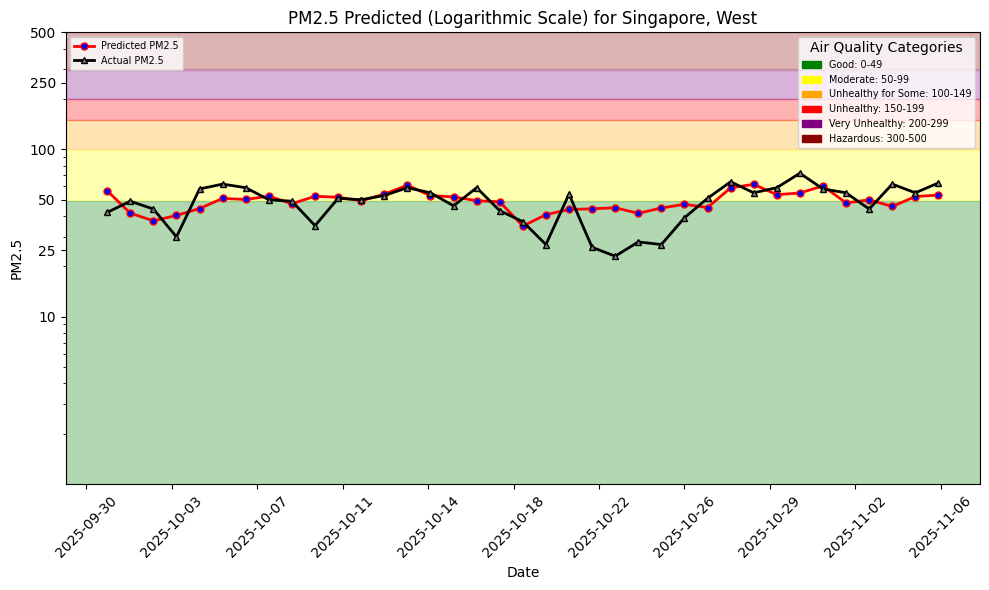

In [1101]:
def plot_air_quality_forecast(city: str, street: str, df: pd.DataFrame, file_path: str, hindcast=False):
    fig, ax = plt.subplots(figsize=(10, 6))

    day = pd.to_datetime(df['date']).dt.date
    # Plot each column separately in matplotlib
    ax.plot(day, df['predicted_pm25'], label='Predicted PM2.5', color='red', linewidth=2, marker='o', markersize=5, markerfacecolor='blue')

    # Set the y-axis to a logarithmic scale
    ax.set_yscale('log')
    ax.set_yticks([0, 10, 25, 50, 100, 250, 500])
    ax.get_yaxis().set_major_formatter(plt.ScalarFormatter())
    ax.set_ylim(bottom=1)

    # Set the labels and title
    ax.set_xlabel('Date')
    ax.set_title(f"PM2.5 Predicted (Logarithmic Scale) for {city}, {street}")
    ax.set_ylabel('PM2.5')

    colors = ['green', 'yellow', 'orange', 'red', 'purple', 'darkred']
    labels = ['Good', 'Moderate', 'Unhealthy for Some', 'Unhealthy', 'Very Unhealthy', 'Hazardous']
    ranges = [(0, 49), (50, 99), (100, 149), (150, 199), (200, 299), (300, 500)]
    for color, (start, end) in zip(colors, ranges):
        ax.axhspan(start, end, color=color, alpha=0.3)

    # Add a legend for the different Air Quality Categories
    patches = [Patch(color=colors[i], label=f"{labels[i]}: {ranges[i][0]}-{ranges[i][1]}") for i in range(len(colors))]
    legend1 = ax.legend(handles=patches, loc='upper right', title="Air Quality Categories", fontsize='x-small')

    # Aim for ~10 annotated values on x-axis, will work for both forecasts ans hindcasts
    if len(df.index) > 11:
        every_x_tick = len(df.index) / 10
        ax.xaxis.set_major_locator(MultipleLocator(every_x_tick))

    plt.xticks(rotation=45)

    if hindcast == True:
        ax.plot(day, df['pm25'], label='Actual PM2.5', color='black', linewidth=2, marker='^', markersize=5, markerfacecolor='grey')
        legend2 = ax.legend(loc='upper left', fontsize='x-small')
        ax.add_artist(legend1)

    # Ensure everything is laid out neatly
    plt.tight_layout()

    # # Save the figure, overwriting any existing file with the same name
    plt.savefig(file_path)
    return plt

file_path = images_dir + "/pm25_hindcast.png"
plt = plot_air_quality_forecast('Singapore', 'West', df, file_path, hindcast=True) 
plt.show()

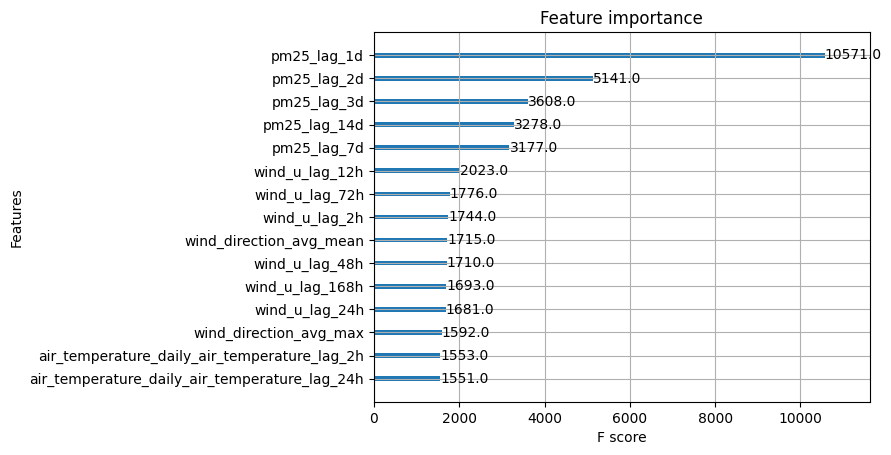

In [1102]:
# Plotting feature importances using the plot_importance function from XGBoost
plot_importance(xgb_regressor, max_num_features=15)
feature_importance_path = images_dir + "/feature_importance.png"
plt.savefig(feature_importance_path)
plt.show()